In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [ ]:
from unsloth import FastVisionModel 
import torch


model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-3B-Instruct",
    load_in_4bit = True, 
    use_gradient_checkpointing = "unsloth", 
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Qwen2 patching. Transformers: 4.50.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.33k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True,
    finetune_language_layers   = True,
    finetune_attention_modules = True, 
    finetune_mlp_modules       = True, 

    r = 16,          
    lora_alpha = 16,  
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False, 
    loftq_config = None, 
)

RuntimeError: Unsloth: You already added LoRA adapters to your model!

In [4]:
from datasets import load_dataset
dataset = load_dataset("SKyu/my-image-captioning-dataset", split = "train")

README.md:   0%|          | 0.00/463 [00:00<?, ?B/s]

(…)-00000-of-00001-3e9e72b53b09ab09.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3100 [00:00<?, ? examples/s]

In [7]:
dataset

Dataset({
    features: ['image', 'prompt'],
    num_rows: 3100
})

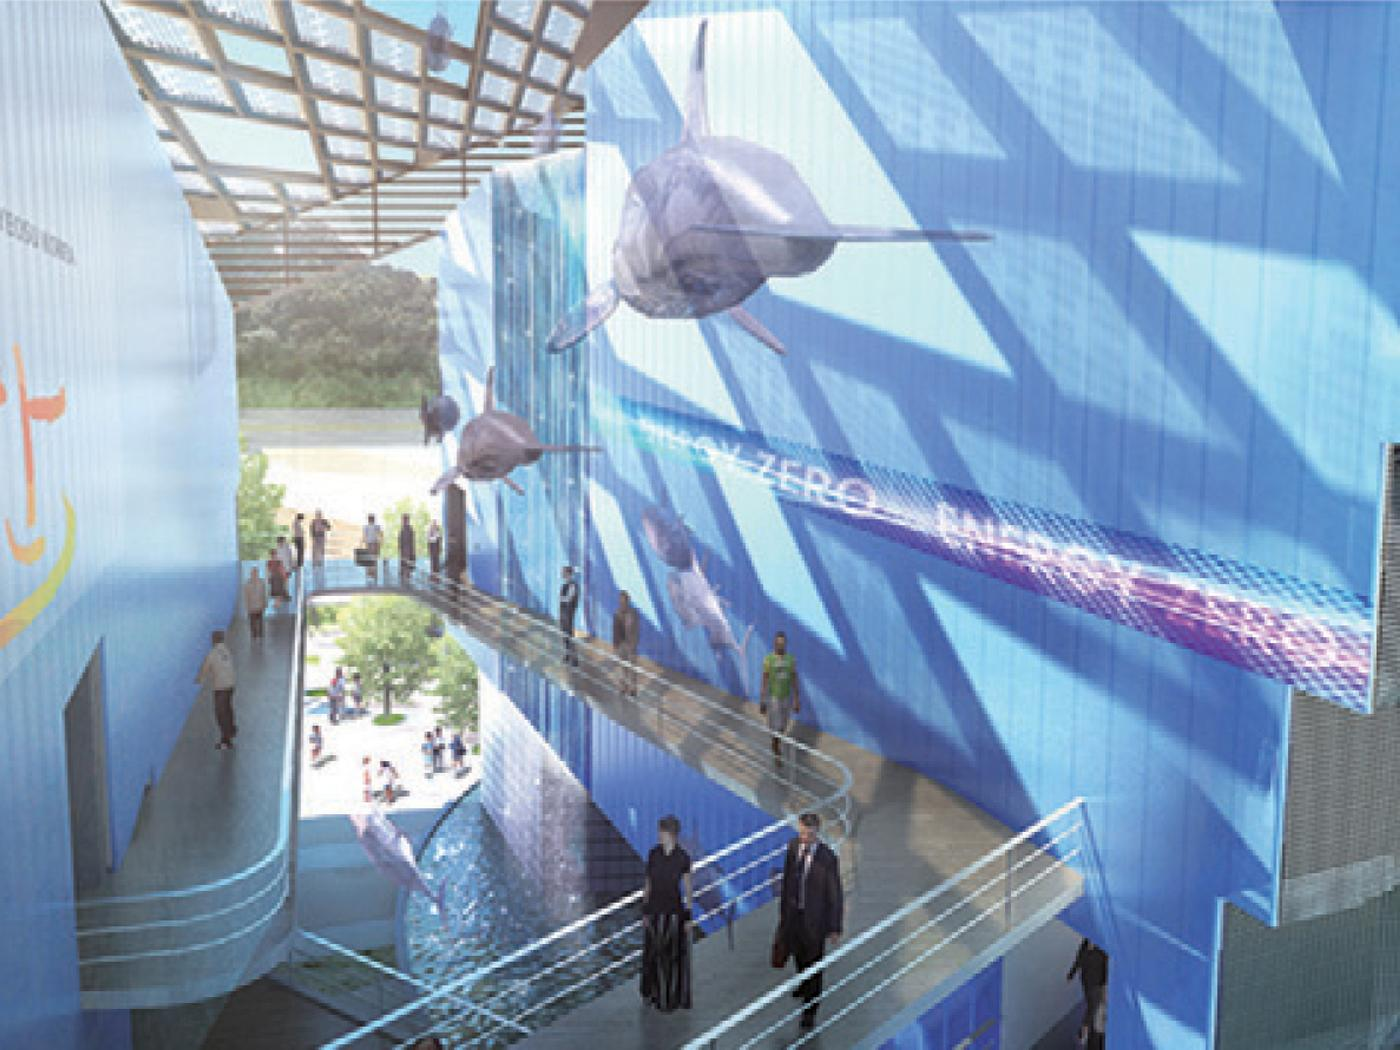

In [8]:
dataset[2]["image"]

In [9]:
dataset[2]["prompt"]

'a group of people standing inside of a building, okinawa churaumi aquarium, concept image, aquarium, a huge glass tank, aisles of aquariums, environmental design, big aquarium, giant aquarium in natural cave, detailed renderings, giant whale tank with legs, energetic atmosphere, biopods, environmental artwork, promotional render, conceptual rendering, enviroment design'

In [10]:
instruction = "Write a description for the image"

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["prompt"]} ]
        },
    ]
    return { "messages" : conversation }
pass

In [11]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [12]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text', 'text': 'Write a description for the image'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x710>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'a large building next to a body of water, conceptual rendering, rendering of checkmate, detailed renderings, dramatic rendering, detailed rendering, sharp hq rendering, futuristic architectural art, artists impression, futuristic sport arena, photoralistic rendering, artistic rendering, architecture render ”, in style of norman foster, artist impression, in style of zaha hadid architect, beautiful rendering'}]}]}

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [14]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,100 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 28,950,528/2,000,000,000 (1.45% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,3.893100
2,3.755900
3,3.920200
4,3.773200
5,3.607700
6,3.120300
7,3.175600
8,3.002600
9,2.869600
10,2.944400


In [17]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["image"]
instruction = "Write a description for the image"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

a blue building with people walking, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people walking in a hallway, people


In [18]:
model.save_pretrained_merged("space-voice-vl", tokenizer,)

Unsloth: Merging weights into 16bit:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/4.42G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:32<00:00, 32.20s/it]
